# Classification

In [47]:
%matplotlib inline
import time
import torch
from torch import nn
from torch.nn import functional 
import torchvision
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

In [48]:
class FashionMNIST(d2l.DataModule):  #@save
    """The Fashion-MNIST dataset."""
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        self.train = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=True)

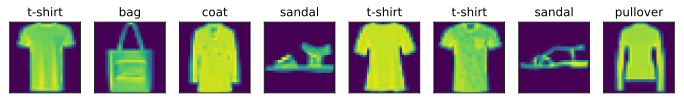

In [49]:
data = FashionMNIST(resize=(32, 32))
len(data.train), len(data.val)


@d2l.add_to_class(FashionMNIST)  #@save this just gives you an array of labels
def text_labels(self, indices):
    """Return text labels."""
    labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(i)] for i in indices] 


@d2l.add_to_class(FashionMNIST)  # get the batch stuffs from the fashion datasets
def get_dataloader(self, train):
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=self.num_workers)


@d2l.add_to_class(FashionMNIST)  #@save
def visualize(self, batch, nrows=1, ncols=8, labels=[]):
    X, y = batch
    if not labels:
        labels = self.text_labels(y)
    d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)
batch = next(iter(data.train_dataloader()))
data.visualize(batch)

In [50]:
class Classifier(d2l.Module):
    def validation_step(self, batch):
        y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(y_hat, batch[-1]), train=False) # this time we plot both!
        self.plot('acc', self.accuracy(y_hat, batch[-1]), train=False) # instead of just the loss.
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)

    # this gets the accuracy of the model as a percentage kind of (NOT THE LOSS)
    def accuracy(self, y_hat, y, averaged=True):
        Y_hat = y_hat.reshape((-1, y_hat.shape[-1]))
        preds = Y_hat.argmax(axis=1).type(y.dtype) # get the max out of every column to turn it into a prediction
        compare = (preds == y.reshape(-1)).type(torch.float32) # compare each of them!
        return compare.mean() if averaged else compare # mean

    


now we implement a softmax regression linear nn model

In [51]:
def softmax(X: torch.Tensor):
    x_exp = torch.exp(X)
    tot = x_exp.sum(1, keepdim=True) # sum each output vector over its elements 
    return x_exp / tot # rescale every vector 



In [52]:
class SoftmaxRegressionClassifier(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma = 0.01):
        super().__init__()
        self.save_hyperparameters()
        # we then  manually define the w matrix and biases (affine translations)
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs),
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]
    def forward(self, X):
        X = X.reshape((-1, self.W.shape[0])) # i dont know what this is but ok
        return softmax(torch.matmul(X,self.W) + self.b)


def cross_entropy(y_hat, y):
    return -torch.log(y_hat[list(range(len(y_hat))), y]).mean() # picks out the prediction value of the correct element, takes the mean, and makes it negative so we can make this minimization (instead of maximization)

@d2l.add_to_class(SoftmaxRegressionClassifier)
def loss(self, y_hat, y):
    return cross_entropy(y_hat, y)
    

In [53]:
class SoftmaxBetter(d2l.Classifier):
    def __init__(self, num_outputs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_outputs)) # flatten probably just doesnt care? dont know

    def forward(self, X):
        return self.net(X)

    def loss(self, y_hat, y, averaged=True):
        y_hat = y_hat.reshape((-1, y_hat.shape[-1]))
        y = y.reshape((-1,))
        return functional.cross_entropy(
            y_hat, y, reduction='mean' if averaged else 'none')


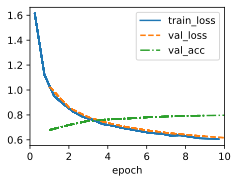

In [54]:
# hand written impl
data = FashionMNIST(batch_size=256)
model=SoftmaxRegressionClassifier(num_inputs=784, num_outputs=10, lr = 0.01)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

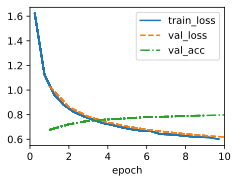

In [55]:
data = FashionMNIST(batch_size=256)
model = SoftmaxBetter(10, 0.01)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)